# NID Feature Analysis Demo

Intention here is to present an example of a work analysis. There was interest in bolstering our predictive model with more infrastructure data. Specifically, I was looking at the **National Inventory of Dams** and the **National Bridge Inventory** datasets. 

What might the correlation look like between dams of poor condition and the damages an area underwent during a severe storm? Could these datasets be used to inform a model, or would they be redundant compared to what was already used?

This notebook won't contain all of the analysis. In fact, I can really only showcase the data cleaning efforts and exploration of this large dataset. The NID data has roughly 80 columns and 90,000 rows and the data entered is not always in the correct form. 

Gathering information that I could use was a challenge, but the reward was well worth it. We were able to use the dam data to aid efforts during Hurricane Helene, in conjunction with USGS river gauge data to identify areas of interest.  

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import contextily as con
from datetime import datetime
from pathlib import Path

import mapclassify


In [123]:
plt.style.use('dark_background')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(20, 10),
    titlesize=25,
    titleweight='normal'
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="larger",
    titleweight="bold",
    titlesize=20,
    titlepad=15
)
plt.rcParams['axes.grid'] = False
plt.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'retina'

In [40]:
dir = Path('/Users/bensalis/Downloads/nation.csv')
df = pd.read_csv(dir, usecols = ['Dam Name', 'NID ID', 'State', 'County', 'Longitude', 'Latitude', 'Owner Types',
                                'Dam Height (Ft)', 'Dam Length (Ft)', 'Volume (Cubic Yards)',
                                'Year Completed', 'Data Last Updated', 'Last Inspection Date', 'Inspection Frequency',
                                'Hazard Potential Classification', 'Condition Assessment'])

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92583 entries, 0 to 92582
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dam Name                         88243 non-null  object 
 1   NID ID                           92581 non-null  object 
 2   Owner Types                      92573 non-null  object 
 3   Latitude                         92424 non-null  float64
 4   Longitude                        92426 non-null  float64
 5   State                            92583 non-null  object 
 6   County                           92425 non-null  object 
 7   Dam Height (Ft)                  82602 non-null  float64
 8   Dam Length (Ft)                  78755 non-null  float64
 9   Volume (Cubic Yards)             45319 non-null  float64
 10  Year Completed                   73674 non-null  float64
 11  Data Last Updated                92583 non-null  object 
 12  Last Inspection Da

In [42]:
df['Condition Assessment'].unique()

array(['Not Rated', nan, 'Not Available', 'Satisfactory', 'Fair',
       'Unsatisfactory', 'Poor'], dtype=object)

In [43]:
df['Hazard Potential Classification'].unique()

array(['Low', 'High', 'Significant', 'Undetermined', nan], dtype=object)

In [44]:
filter = (
    (df['Condition Assessment'].isin(['Unsatisfactory', 'Poor', 'Satisfactory', 'Fair'])) & (
    df['Hazard Potential Classification'].isin(['Low', 'Significant', 'High']))
    )

filter.sum() #filters out about 60k dams

33858

In [45]:
primary = df[filter].copy()
primary['Condition Assessment'].replace(['Unsatisfactory', 'Poor', 'Satisfactory', 'Fair'], [0,1,2,3], inplace= True)
primary['Hazard Potential Classification'].replace(['Low', 'Significant','High'], [0, 1, 2], inplace= True)

primary.head()

,Dam Name,NID ID,Owner Types,Latitude,Longitude,State,County,Dam Height (Ft),Dam Length (Ft),Volume (Cubic Yards),Year Completed,Data Last Updated,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment
8,Asso.Minerals (Usa) Ltd. Dam,FL00155,Private,29.890339,-81.706600,Florida,Clay,20.0,11170.0,2220.0,1970.0,05/04/2023,07/31/2014,NaN,1,2
11,Girl Scouts of Usa Dam,NC02637,Private,35.235600,-81.265000,North Carolina,Gaston,NaN,290.0,NaN,1982.0,06/09/2025,01/16/2025,NaN,2,3
12,Engineer Lake,LA00171,Federal,31.120193,-93.077118,Louisiana,Vernon,23.0,700.0,NaN,1964.0,05/30/2024,04/29/2019,4.0,0,0
13,Dam 29,TX07242,Federal,31.181977,-97.849519,Texas,Coryell,26.0,525.0,10111.0,1995.0,05/30/2024,09/14/2020,4.0,0,3
15,Alligator Lake,LA00170,Federal,31.144632,-93.153289,Louisiana,Vernon,34.0,1000.0,NaN,1955.0,05/30/2024,04/28/2019,4.0,0,1


In [ ]:
primary['Last Inspection Date'] = pd.to_datetime(df['Last Inspection Date'], errors= 'coerce')
primary['Data Last Updated'] = pd.to_datetime(df['Data Last Updated'])

today = datetime.today()
primary['age_yrs'] = 2026 - primary['Year Completed']
primary['yrs_since_insp'] = np.round(primary['Last Inspection Date'].apply(lambda x: (today - x).days / 365), 2)
primary['yrs_data_update'] = np.round(primary['Data Last Updated'].apply(lambda x: (today - x).days / 365), 2)

primary.reset_index(drop= True, inplace= True)
primary.sort_values(by = 'age_yrs',ascending= False, inplace= True)
primary.head()

,Dam Name,NID ID,Owner Types,Latitude,Longitude,State,County,Dam Height (Ft),Dam Length (Ft),Volume (Cubic Yards),Year Completed,Data Last Updated,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,age_yrs,yrs_since_insp,yrs_data_update
0,Ipswich Mills Dam,MA00231,Local Government,42.677671,-70.837774,Massachusetts,Essex,NaN,180.0,NaN,1637.0,2024-08-28,2020-09-04,10.0,0,3,389.0,5.38,1.4
1,Old Oaken Bucket Pond Dam,MA01041,Local Government,42.177578,-70.750268,Massachusetts,Plymouth,NaN,370.0,NaN,1640.0,2024-08-28,2018-04-05,5.0,1,2,386.0,7.80,1.4
2,Lower Shawme Lake Dam,MA02470,Local Government,41.757730,-70.500454,Massachusetts,Barnstable,NaN,120.0,NaN,1654.0,2024-08-28,2019-06-11,5.0,1,2,372.0,6.62,1.4
3,Central Street Dam,MA00340,Private,42.324916,-71.401548,Massachusetts,Middlesex,NaN,400.0,NaN,1659.0,2024-08-28,2024-03-22,2.0,2,3,367.0,1.83,1.4
4,Nye Pond Dam,MA02469,State,41.728471,-70.431703,Massachusetts,Barnstable,NaN,230.0,NaN,1669.0,2024-08-28,2020-03-18,5.0,1,1,357.0,5.85,1.4


In [59]:
geo_df = gp.GeoDataFrame(primary, geometry=gp.points_from_xy(x = primary.Longitude, y = primary.Latitude), crs=4326)

In [ ]:
geo_df.State.unique() #only looking at CONUS states for right now... Will confine coordinates.

array(['Massachusetts', 'Connecticut', 'Maryland', 'New Jersey',
       'New Hampshire', 'North Carolina', 'Pennsylvania', 'Maine',
       'South Carolina', 'Rhode Island', 'New York', 'Wisconsin',
       'Delaware', 'West Virginia', 'Vermont', 'Indiana', 'Michigan',
       'Ohio', 'Kentucky', 'Georgia', 'Virginia', 'Texas', 'California',
       'Minnesota', 'Kansas', 'Idaho', 'Colorado', 'Utah', 'Iowa',
       'Illinois', 'Arizona', 'Arkansas', 'Nebraska', 'Washington',
       'Nevada', 'Montana', 'Hawaii', 'Wyoming', 'New Mexico', 'Oregon',
       'Louisiana', 'Tennessee', 'North Dakota', 'Mississippi', 'Alaska',
       'Missouri', 'Oklahoma', 'South Dakota', 'Puerto Rico', 'Alabama',
       'Florida', 'Guam'], dtype=object)

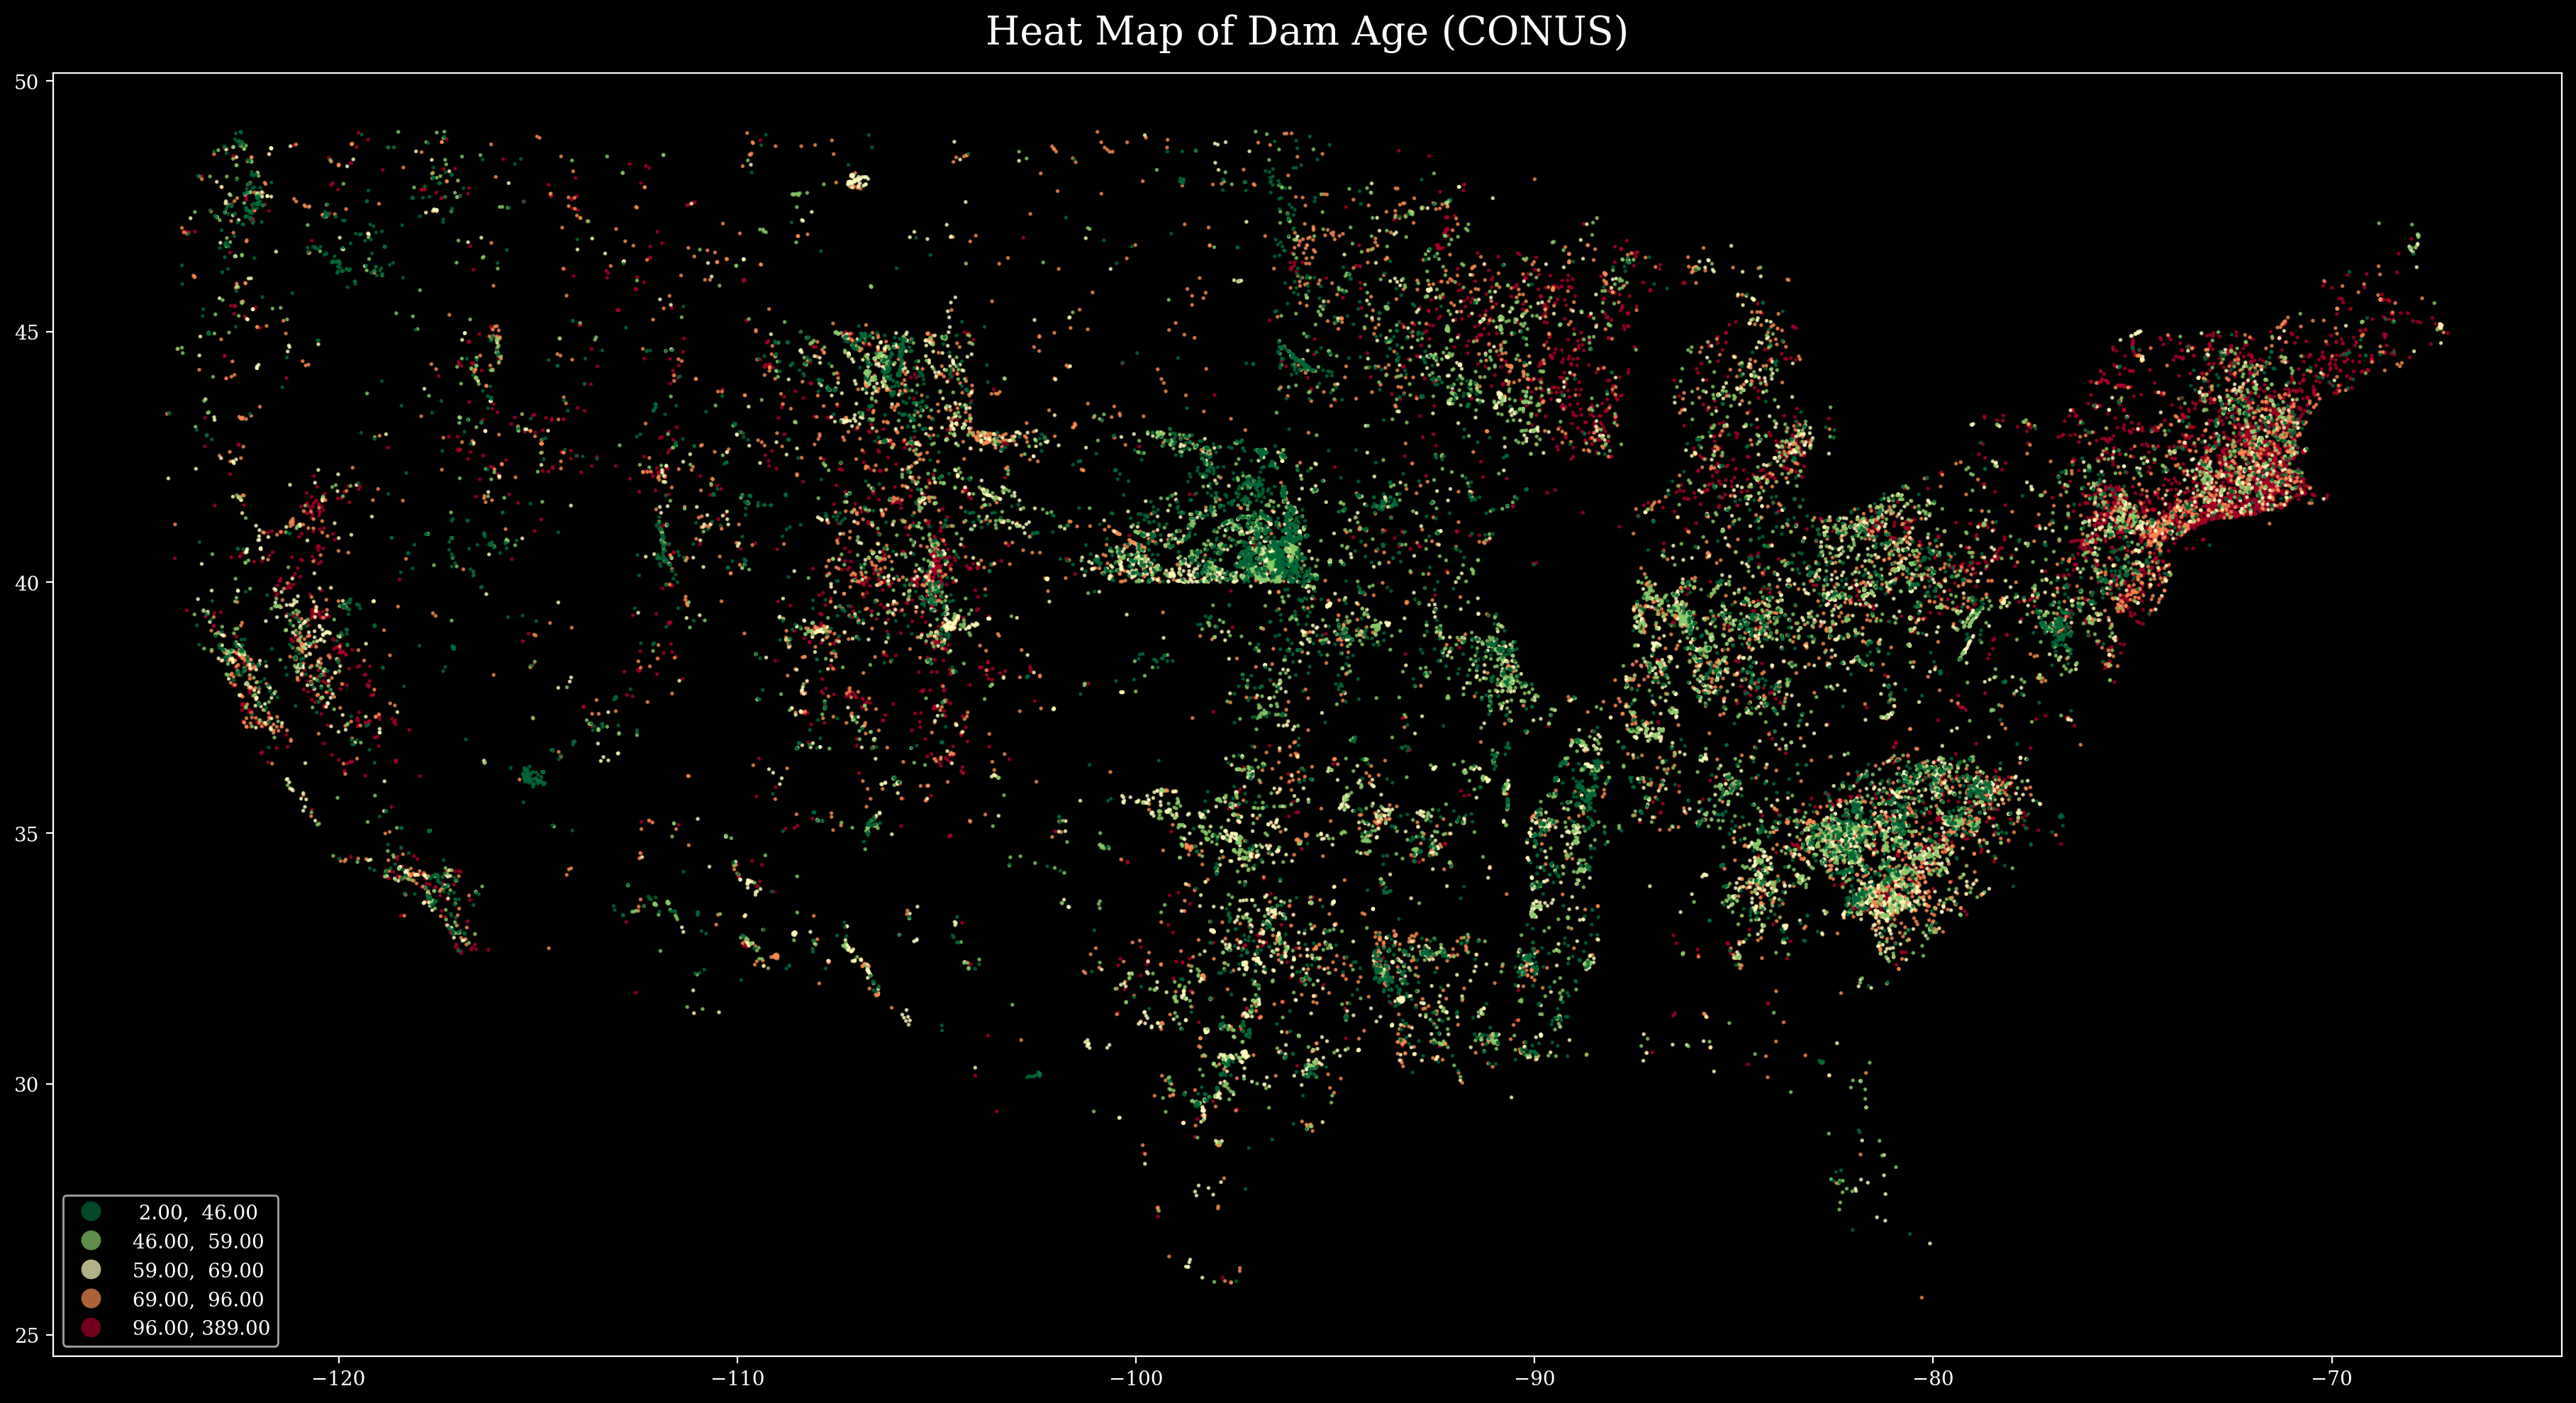

In [ ]:
mask = (geo_df.Longitude > -125) & (geo_df.Longitude < -67) & (geo_df.Latitude > 25)
ax = geo_df[mask].plot(column= 'age_yrs', cmap = 'RdYlGn_r',scheme='quantiles', markersize=1, alpha = 0.7, legend= True)
ax.set_title('Heat Map of Dam Age (CONUS)', fontdict={'fontweight':'normal'})
ax.legend_

#taking a look at geographic distributions. Nothing too helpful